This notebook contains an example of using word2vec to generate similar words for the crossword. **The distinguishing feature here is that we will update the model with additional information (and vocabulary) to see if the results improve.** The input is the words, along with the clues, which are used to supplement the context.

# Crossword words using word2vec

Define the input words list. Input words are taken from a crossword.

In [0]:
words_list = ['Porbandar', 'Putli_Bai', 'Ram', 'Time', 'India', 'Aga', 'Abdul'
              , 'soul', 'Charkha', 'butter', 'lawyer', 'Naidu', 'railway'
              , 'quit', 'laugh', 'water', 'earth', 'evil', 'Dandi']

### Setup

Download the pre-trained word vectors; this takes a minute (~1.5gb)

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-11-13 08:31:46--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.133.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.133.141|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Install gensim, a useful NLP library that we will use to load word2vec embeddings

In [0]:
!pip install gensim
from gensim.models import KeyedVectors

In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
model1 = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

2019-11-13 08:31:51,094 : INFO : loading projection weights from /root/input/GoogleNews-vectors-negative300.bin.gz
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-11-13 08:33:32,184 : INFO : loaded (3000000, 300) matrix from /root/input/GoogleNews-vectors-negative300.bin.gz


Add logging support.

In [0]:
import logging
from pprint import pprint # pretty print output
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Adding option to upload file.

In [0]:
from google.colab import files

uploaded = files.upload()
document = ""
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  document = document + "\n" + uploaded[fn].decode('UTF-8')

Saving An-Autobiography.txt to An-Autobiography.txt
Saving hind_swaraj.txt to hind_swaraj (1).txt
Saving the-voice-of-truth.txt to the-voice-of-truth (1).txt
Saving Mahatma_Vol1.txt to Mahatma_Vol1.txt
Saving Mahatma_Vol2.txt to Mahatma_Vol2.txt
Saving Mahatma_Vol3.txt to Mahatma_Vol3.txt
Saving Mahatma_Vol4.txt to Mahatma_Vol4.txt
Saving Mahatma_Vol5.txt to Mahatma_Vol5.txt
Saving Mahatma_Vol7.txt to Mahatma_Vol7.txt
Saving Mahatma_Vol8.txt to Mahatma_Vol8.txt
Saving GandhiAutobio_morallessons.txt to GandhiAutobio_morallessons.txt
Saving gandhi_a_life.txt to gandhi_a_life.txt
Saving mahatma-gandhi-his-life-and-times.txt to mahatma-gandhi-his-life-and-times.txt
Saving selected_lettersVol_IV.txt to selected_lettersVol_IV.txt
User uploaded file "An-Autobiography.txt" with length 1013862 bytes
User uploaded file "hind_swaraj.txt" with length 182585 bytes
User uploaded file "the-voice-of-truth.txt" with length 778854 bytes
User uploaded file "Mahatma_Vol1.txt" with length 961514 bytes
User

Let's tokenize the document.

In [0]:
from pprint import pprint  # pretty-printer
import nltk
nltk.download('punkt')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Remove stop words from the document.

In [0]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
# adding from https://gist.github.com/sebleier/554280
stop_words = stop_words.union(set(["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]))

def compute_max_distance(word):
  max = 0
  for w in words_list:
    if w not in model1.wv.vocab:
      continue
    d = model1.similarity(word, w)
    if max < d:
      max = d
  return max

def compute_min_distance(word):
  min = 0
  for w in words_list:
    if w not in model1.wv.vocab:
      continue
    d = model1.similarity(word, w)
    if min > d:
      min = d
  return min

def compute_avg_distance(word):
  sums = 0
  n = 0
  for w in words_list:
    if w not in model1.wv.vocab:
      continue
    d = model1.similarity(word, w)
    sums += d
    n += 1
  return sums/n

words_found = []
def check_if_word_already_present(word):
  if word in model1.wv.vocab:
    return word
  if word.lower() in model1.wv.vocab:
    words_found.append(word.lower())
    return word.lower()
  if word.upper() in model1.wv.vocab:
    words_found.append(word.upper())
    return word.upper()
  if word.title() in model1.wv.vocab:
    words_found.append(word.title())
    return word.title()
  return word

removed_words = []
def remove_stop_words(s):
  word_tokens = word_tokenize(s) 
  filtered_sentence = [w for w in word_tokens if w not in stop_words and w.lower() not in stop_words]
  new_set = list(map(check_if_word_already_present, filtered_sentence))
  for w in new_set:
    if w not in model1.wv.vocab:
      continue
    similarity = compute_min_distance(w)
    if similarity < 0.1:
      new_set.remove(w)
      removed_words.append(w)
  new_sent = ' '.join(new_set)
  return new_sent

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import string

#removes punctuation from a sentence
def remove_punctuation(s):
  table = str.maketrans({key: None for key in string.punctuation})
  s = s.replace('”', '')
  s = s.replace('“', '')
  s = s.replace('‘', '')
  s = s.replace('’', '')
  s = s.replace('—', '')
  s = remove_stop_words(s)
  s = ''.join([i for i in s if not i.isdigit()])
  return s.translate(table) 

In [0]:
tokenized_document = tokenizer.tokenize(document)
tokenized_document = list(map(remove_punctuation, tokenized_document))
# convert each word to lowercase
final_document = [line.lower().split() for line in tokenized_document]
#pprint(final_document)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local

In [0]:
from nltk.probability import FreqDist
stoplist_doc = []
for line in final_document:
  for w in line:
    stoplist_doc.append(w)
fdist = FreqDist(stoplist_doc)
#pprint(fdist.most_common(100))

Let us update the model with added vocabulary and context.

In [0]:
from gensim.models import Word2Vec
model_2 = Word2Vec(size=300, min_count=1)
model_2.build_vocab(final_document)
total_examples = model_2.corpus_count
model_2.build_vocab([list(model1.vocab.keys())], update=True)
model_2.intersect_word2vec_format(EMBEDDING_FILE, binary=True, lockf=1.0)
model_2.train(final_document, total_examples=total_examples, epochs=model_2.iter)

2019-11-13 10:51:54,815 : INFO : collecting all words and their counts
2019-11-13 10:51:54,817 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-13 10:51:54,826 : INFO : PROGRESS: at sentence #10000, processed 25696 words, keeping 6904 word types
2019-11-13 10:51:54,839 : INFO : PROGRESS: at sentence #20000, processed 54774 words, keeping 11007 word types
2019-11-13 10:51:54,855 : INFO : PROGRESS: at sentence #30000, processed 91837 words, keeping 14756 word types
2019-11-13 10:51:54,869 : INFO : PROGRESS: at sentence #40000, processed 126447 words, keeping 17533 word types
2019-11-13 10:51:54,884 : INFO : PROGRESS: at sentence #50000, processed 160524 words, keeping 19700 word types
2019-11-13 10:51:54,896 : INFO : PROGRESS: at sentence #60000, processed 193179 words, keeping 21631 word types
2019-11-13 10:51:54,917 : INFO : PROGRESS: at sentence #70000, processed 223374 words, keeping 23025 word types
2019-11-13 10:51:54,938 : INFO : PROGRESS: at sent

(1759403, 1785245)

In [0]:
model = model_2

## Problem
The goal is to find interesting related words given a set of words **and clues**, i.e. understand the ‘theme’ and get an effective ranking of the words.

Before we start, let us define an auxillary method which will remove words from the list which are not present in the vocabulary.

In [0]:
# filters words not in the model vocabulary
def filter_words_not_in_vocab(model, list_of_words):
    word_vectors = model.wv
    return list(filter(lambda x: x in word_vectors.vocab, list_of_words))

Additionally, we will need to remove words which have the same root as the input word.

In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def filter_words_with_same_root(input_words):
  def should_filter(word):
    for x in input_words:
      if(stemmer.stem(x) == stemmer.stem(word) or x in word or word in x):
        return False
    return True
  return should_filter

### Metric for ranking: Frequency count
This method finds the words which occur most number of times within top-N cosine distance of each input word.


In [0]:
from itertools import chain
from collections import Counter

# this method takes in a list of words and returns top 20 words which are 
# closest to most of the input words. 
def find_highest_frequency(model, list_of_words, nwords=20):
    closest_words = []
    map_words = []
    for word in list_of_words:
        words = model.similar_by_word(word, topn=50, restrict_vocab=None)
        words = [x[0] for x in words]
        for y in words:
          map_words.append([word, y])
        closest_words = closest_words + words
    freq_count = Counter(chain(closest_words)).most_common(nwords)
    return [x[0] for x in freq_count]

## Gandhi 150

### Results without clues feeded to word2vec.

2. Filter words not in vocabulary.

In [0]:
filtered_words_list = filter_words_not_in_vocab(model, words_list)
words_not_in_vocab = set(words_list) - set(filtered_words_list)
print("Following {} words not in vocab:".format(len(words_not_in_vocab)), words_not_in_vocab)

Following 1 words not in vocab: {'Putli_Bai'}


3. Compute most similar words using metric 2.

In [0]:
closest_words = find_highest_frequency(model, filtered_words_list)
closest_words = list(filter(filter_words_with_same_root(words_list), closest_words))
pprint(closest_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # Remove the CWD from sys.path while we load stuff.
2019-11-13 11:03:41,345 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['himsa',
 'mahomedan',
 'ramanama',
 'khidmatgar',
 'sumtotal',
 'godfearing',
 'granth',
 'selfdenial',
 'ramanam',
 'selfcontrol',
 'nonkilling',
 'Gujarat',
 'selfrealization',
 'tulsidas',
 'ahimsa…',
 'neverfailing',
 'lettersi',
 'allpervading',
 'selfexamination',
 'lettersii']


### Adding clues to words.
Next we want to see can we enhance the results by adding clue information to the words.
1. Define clue list.

In [0]:
clue_list = ["Gandhi's birthplace", 
             "Gandhi's mother", 
             "Hey : Gandhi's last words", 
             "Gandhi was Magazine's Man of the Year in 1930",
             "Young : A journal published by Gandhi", 
             "Gandhi and Kasturba were jailed at Khan palace",
             "Khan Gaffar Khan was also known as Frontier Gandhi",
             "Mahatma means Great", 
             "The spinning wheel made iconic by Gandhi",
             "The villagers want bread not: quote by Gandhi",
             "Gandhi's profession in South Africa",
             "Sarojni became president of the Indian National Congress after Gandhi",
             "Gandhi was thrown out of the train at Pietermaritzburg Station",
             "Gandhi started the India Movement in 1942",
             "First they ignore you, then they at you, then they fight you, then you win: quote by Gandhi",
             "We may not be God, but we are of God, even as a little drop is of the ocean: quote by Gandhi",
             "provides enough to satify every man's needs, but not every man's greed: quote by Gandhi",
             "Good and are found together: quote by Gandhi",
             "Gandhi led the Salt March to this beach"]

2. Next, add a function which will extract nouns from the clue. We will use [nltk](https://en.wikipedia.org/wiki/Natural_Language_Toolkit), a suite of libraries and programs for symbolic and statistical natural language processing (NLP) for English written in the Python programming language.

In [0]:
from textblob import TextBlob
import nltk
nltk.download('punkt')
!python -m textblob.download_corpora

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [0]:
def extract_nouns(txt):
  return [w for (w, pos) in TextBlob(txt).pos_tags if pos[0] == 'N']

In [0]:
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import RegexpParser
from nltk import Tree
import pandas as pd

# Defining a grammar & Parser
NP = "NP: {(<V\w+>|<NN\w?>)+.*<NN\w?>}"
chunker = RegexpParser(NP)

def get_continuous_chunks(text, chunk_func=ne_chunk):
    chunked = chunk_func(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


3. Extract nouns for each clue.

In [0]:
clue_nouns = list(map(extract_nouns, clue_list))
pprint(clue_nouns)

[['Gandhi', 'birthplace'],
 ['Gandhi', 'mother'],
 ['Hey', 'Gandhi', 'words'],
 ['Gandhi', 'Magazine', 'Man', 'Year'],
 ['Young', 'journal', 'Gandhi'],
 ['Gandhi', 'Kasturba', 'Khan', 'palace'],
 ['Khan', 'Gaffar', 'Khan', 'Frontier', 'Gandhi'],
 ['Mahatma', 'Great'],
 ['spinning', 'wheel', 'Gandhi'],
 ['villagers', 'quote', 'Gandhi'],
 ['Gandhi', 'profession', 'South', 'Africa'],
 ['Sarojni', 'president', 'National', 'Congress', 'Gandhi'],
 ['Gandhi', 'train', 'Pietermaritzburg', 'Station'],
 ['Gandhi', 'India', 'Movement'],
 ['quote', 'Gandhi'],
 ['God', 'God', 'drop', 'ocean', 'quote', 'Gandhi'],
 ['man', 'needs', 'man', 'greed', 'quote', 'Gandhi'],
 ['quote', 'Gandhi'],
 ['Gandhi', 'Salt', 'March', 'beach']]


Let us try to extract the noun phrases too.

In [0]:
clue_noun_phrases = list(map(get_continuous_chunks, clue_list))
pprint(clue_noun_phrases)

[['Gandhi'],
 ['Gandhi'],
 ['Gandhi'],
 ['Gandhi', 'Magazine'],
 ['Young'],
 ['Gandhi', 'Kasturba', 'Khan'],
 ['Khan Gaffar Khan'],
 ['Mahatma'],
 [],
 [],
 ['Gandhi'],
 ['Sarojni', 'Indian National Congress'],
 ['Gandhi'],
 ['Gandhi', 'India'],
 [],
 ['God'],
 [],
 ['Good'],
 ['Gandhi', 'Salt']]


Since the noun phrases are not that good, we stick to simply using the nouns. Next, we can try adding these words also as input to the model and see the results.

In [0]:
flattened_clue_list = [item for sublist in clue_nouns for item in sublist]
added_words_list = words_list + flattened_clue_list
#pprint(added_words_list)

Again, filter out the words not in vocabulary.

In [0]:
filtered_words_list = filter_words_not_in_vocab(model, added_words_list)
words_not_in_vocab = set(added_words_list) - set(filtered_words_list)
print("Following {} words not in vocab:".format(len(words_not_in_vocab)), words_not_in_vocab)

Following 1 words not in vocab: {'Putli_Bai'}


Compute most similar words.

In [0]:
closest_words = find_highest_frequency(model, filtered_words_list, nwords=40)
closest_words = list(filter(filter_words_with_same_root(added_words_list), closest_words))
pprint(closest_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['salt_satyagraha',
 'Karunanidhi',
 'Gadkari',
 'Joshi',
 'Vinoba',
 'Bapu',
 'Ambedkar',
 'Pandit_Nehru',
 'Swami_Vivekananda',
 'Tagore',
 'Hind_Swaraj',
 'Shri_Guruji',
 'Bhagat_Singh',
 'Advani',
 'Mayawati',
 'Modi',
 'Rahul',
 'Basu',
 'Mamata',
 'Subhash_Chandra_Bose',
 'Ghandi',
 'Vinoba_Bhave']


We can also try merging the clues and the words list, so that we get top word which is most similar, and feed them to the model.

In [0]:
clues_words_combined = []
for x in range(len(words_list)):
  clues_words_combined.append(filter_words_not_in_vocab(model,[words_list[x]] + clue_nouns[x]))
# replace each word list by most similar word
closest_words = []
for x in clues_words_combined:
  words = model.most_similar(positive=x, topn=1)
  words = [x[0] for x in words]
  closest_words += words
pprint(closest_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Kirti_Mandir',
 'father',
 'gandhi',
 'Life_Expectancy_Hits',
 'Gandhiji',
 'Bahadur_Shah',
 'Hussain',
 'tulsidas',
 'charkha',
 'millhusked',
 'country',
 'sangh',
 'railway_station',
 'swaraj',
 'mahatma',
 'god',
 'ramanama',
 'granth',
 'Dandi_march']


We can even try getting closest words from these words.

In [0]:
result_words = find_highest_frequency(model, closest_words, nwords=40)
result_words = list(filter(filter_words_with_same_root(added_words_list), result_words))
# remove potential duplicates
final_words = []
for word in result_words:
  is_similar = False
  for x in final_words:
    if stemmer.stem(x) == stemmer.stem(word) or x in word or word in x:
      is_similar = True
      break
  if not is_similar:
    final_words.append(word)
pprint(final_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['ramayana',
 'ishopanishad',
 'bibhishan',
 'ramdas',
 'kunzru',
 'selfrealization',
 'bhagavadgita',
 'mahatmaship',
 'ablebodied',
 'samskrit',
 'godfearing',
 'gandhikijai',
 'mahomedan',
 'lettersi',
 'splendour',
 'harijans',
 'himalayas',
 'Sabarmati_Ashram',
 'slade',
 'vithalbhai',
 'kumarappa',
 'desaii',
 'shraddhanand',
 'satyagraha',
 'granth',
 'learnt',
 'himsa',
 'interdining',
 'selfdenial',
 'bhangis',
 'allembracing',
 'mahadev',
 'ramdhun',
 'neighbour']


In [0]:
# sorting the words according to avg distance from answer words
dist_matrix = []
for w in final_words:
  dist = 0
  for v in filtered_words_list:
    dist += model.similarity(w, v)
  dist_matrix.append(dist)

pprint([x for _,x in sorted(zip(dist_matrix,final_words))])

['Sabarmati_Ashram',
 'selfrealization',
 'lettersi',
 'himsa',
 'bhagavadgita',
 'selfdenial',
 'neighbour',
 'interdining',
 'mahomedan',
 'godfearing',
 'allembracing',
 'bibhishan',
 'ramdhun',
 'bhangis',
 'gandhikijai',
 'harijans',
 'satyagraha',
 'samskrit',
 'learnt',
 'ramdas',
 'himalayas',
 'kumarappa',
 'splendour',
 'ishopanishad',
 'ablebodied',
 'mahatmaship',
 'ramayana',
 'granth',
 'kunzru',
 'mahadev',
 'desaii',
 'slade',
 'shraddhanand',
 'vithalbhai']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
model.most_similar(positive=["husband", "Kasturba"], negative=["Gandhi"], topn=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wife', 0.6479916572570801)]

Let us try to establish relationships between words.

In [0]:
import numpy as np
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def cosine_similarity(v1, v2):
   v1_u = unit_vector(v1)
   v2_u = unit_vector(v2)
   return np.dot(v1_u, v2_u)

In [0]:
model1.similarity("means", "Gandhi")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.01554533

In [0]:
a = "China"
b = "Beijing"
a_vector_list = model.most_similar(positive=[a], topn=10)
b_vector_list = model.most_similar(positive=[b], topn=10)
print(a_vector_list)
print(b_vector_list)
for v in a_vector_list:
  for w in b_vector_list:
    #print("Trying:",v[0], b, a)
    similar = model.most_similar(positive=[v[0], b], negative=[a], topn=1)
    similar = [x[0] for x in similar]
    #print(similar, w[0], v[0])
    if(w[0] in similar):
      print(v[0], w[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.pa

[('Chinese', 0.767808198928833), ('Beijing', 0.76484614610672), ('Taiwan', 0.7081156969070435), ('Chinas', 0.6899173259735107), ('Shanghai', 0.6727434396743774), ('Guangdong', 0.6721153259277344), ('Hainan', 0.6360341310501099), ('Chinaâ_€_™', 0.6301891803741455), ('Hong_Kong', 0.624097466468811), ('Shenzhen', 0.6239033937454224)]
[('China', 0.76484614610672), ('Bejing', 0.7616671323776245), ('Shanghai', 0.7191921472549438), ('Beijng', 0.6974372863769531), ('Guangzhou', 0.6878911256790161), ('Chinese', 0.6758180856704712), ('Taipei', 0.6497264504432678), ('inBeijing', 0.6339085102081299), ('Hu', 0.6303641200065613), ('Beijing_Olympics', 0.6279826164245605)]
Beijing Bejing
Taiwan Taipei
Chinas Bejing
Shanghai Guangzhou
Guangdong Guangzhou
Hong_Kong Shanghai
Shenzhen Guangzhou


In [0]:
plot_words = ["Mahatma"]
for word in list(words_found):
  if not (model[word] == model1[word]).all():
    plot_words.append(word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
plot_words = list(set(plot_words))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


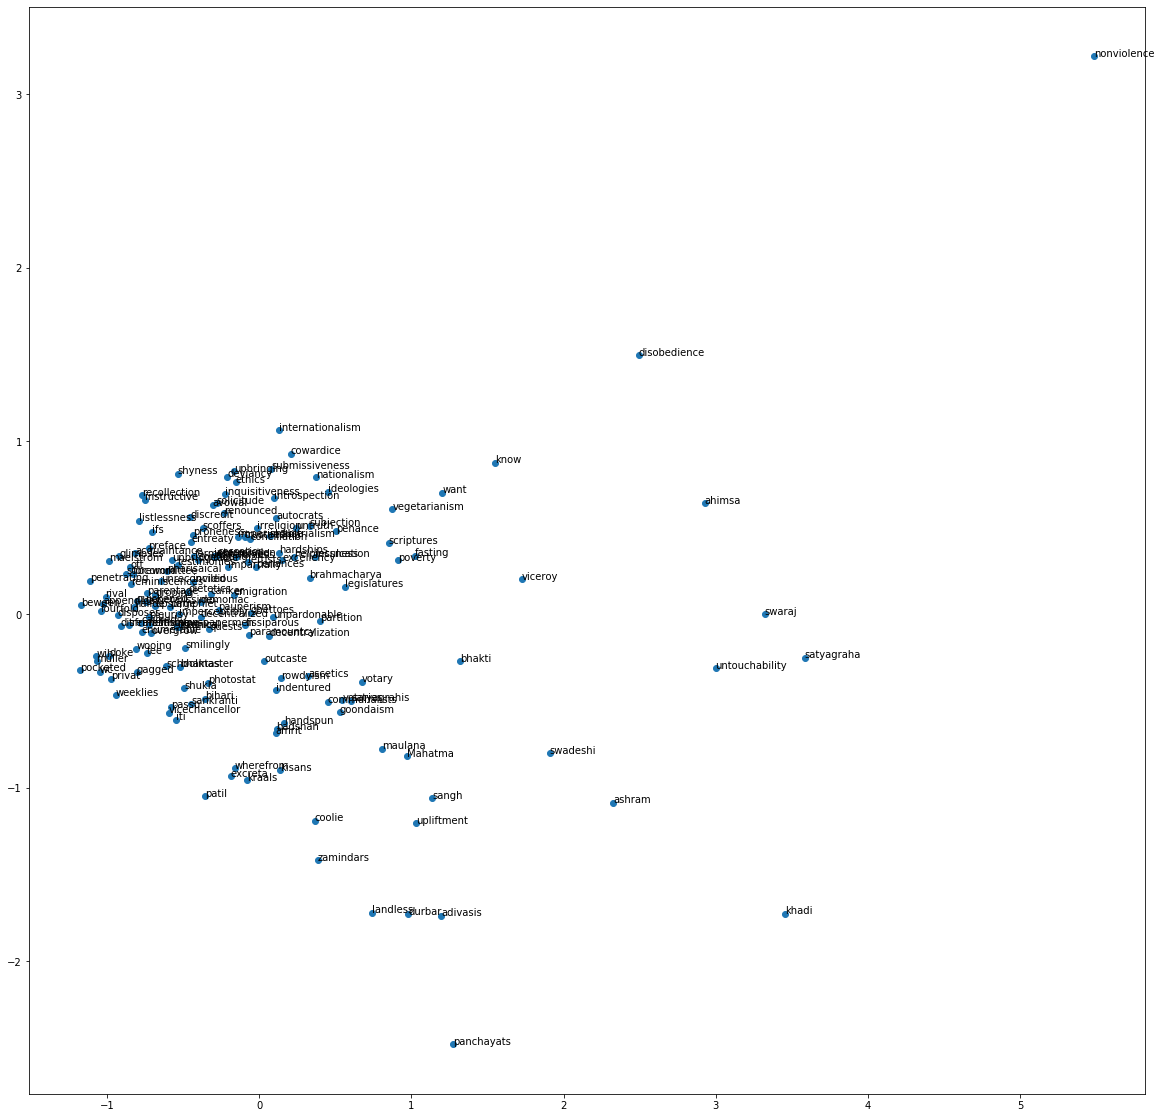

In [0]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model[plot_words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.figure(figsize=(20,20))
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = plot_words
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

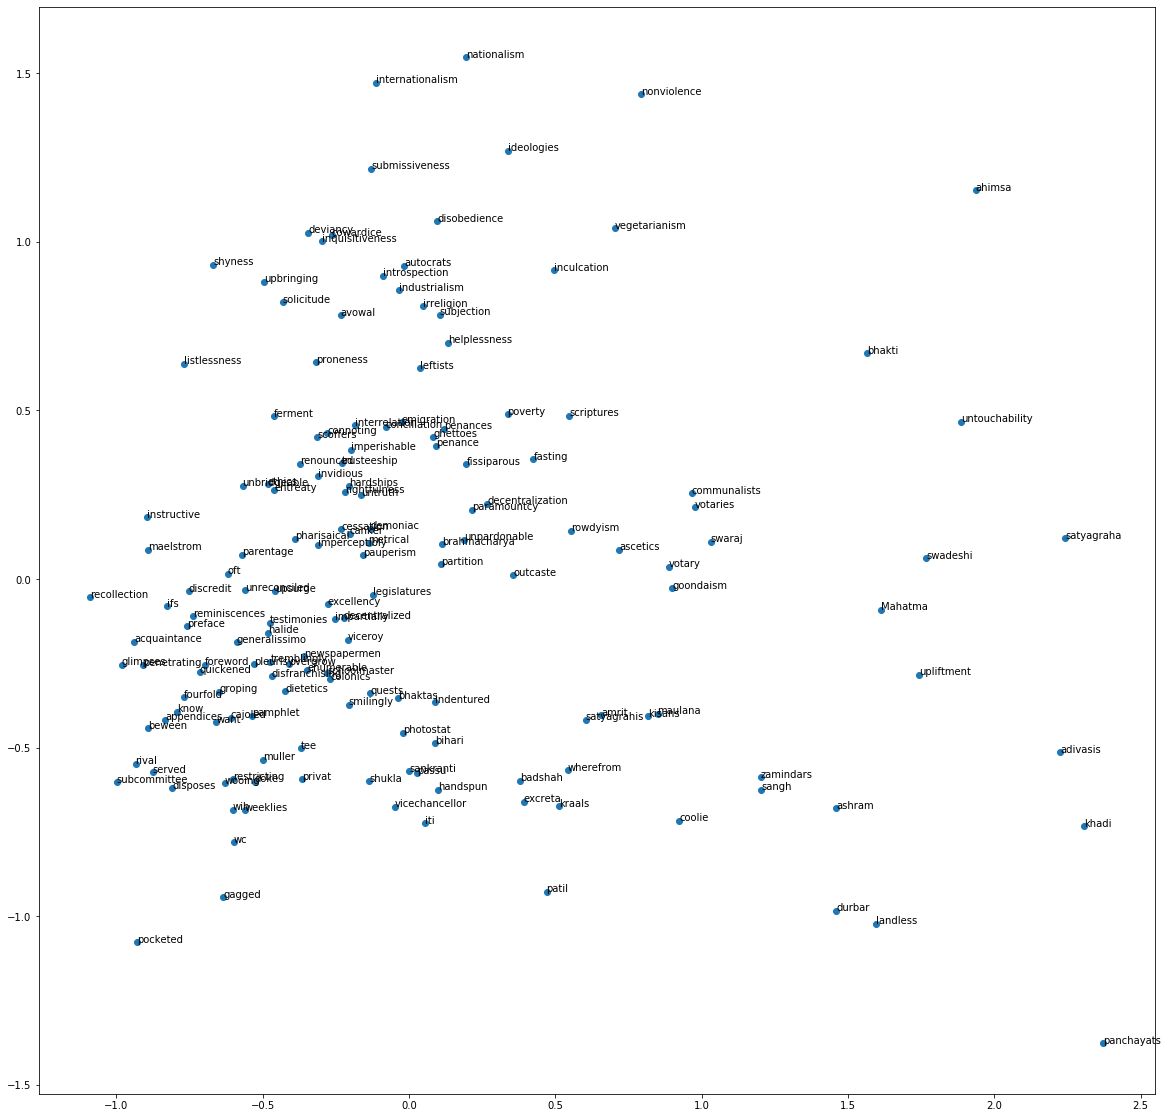

In [0]:
X = model1[plot_words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.figure(figsize=(20,20))  
pyplot.scatter(result[:, 0], result[:, 1])
words = plot_words
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()